In [57]:
!pip install datasets

In [58]:
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# **Dataset**

## CoNLL2003 Dataset

In [59]:
ner_dataset = load_dataset("conll2003")

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [60]:
def flatten_conll_dataset(dataset):
  tokens = []
  labels = []
  for example in dataset:
    tokens.extend((example['tokens']))
    labels.extend((example['ner_tags']))
  return tokens, labels

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301418 entries, 0 to 301417
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   tokens    301418 non-null  object
 1   ner_tags  301418 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB
None


First few rows:
    tokens ner_tags
0       EU    B-ORG
1  rejects        O
2   German   B-MISC
3     call        O
4       to        O


Token and Entity Distribution:
tokens
,      10876
.      10874
the    10672
of      5426
in      5073
to      5067
a       4414
(       4226
)       4225
and     4180
Name: count, dtype: int64


ner_tags
O         250660
B-LOC      10645
B-PER      10059
B-ORG       9323
I-PER       6991
I-ORG       5290
B-MISC      5062
I-MISC      1717
I-LOC       1671
Name: count, dtype: int64




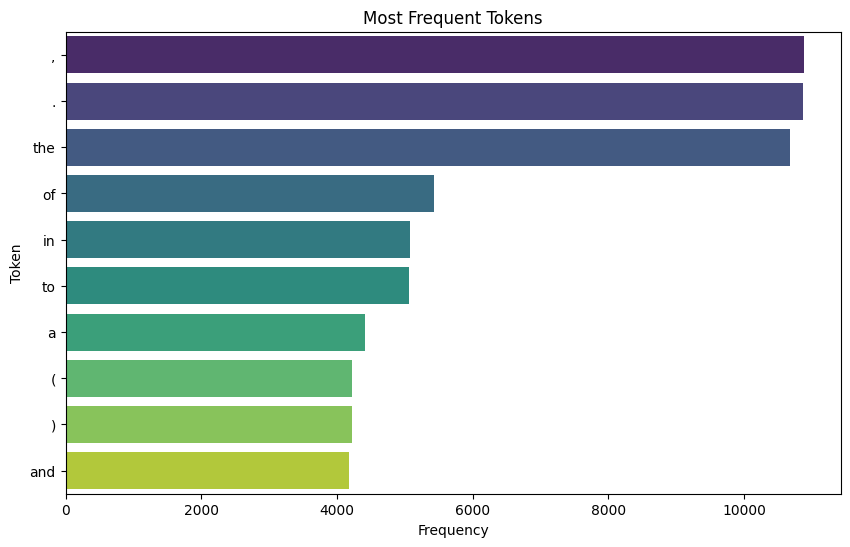

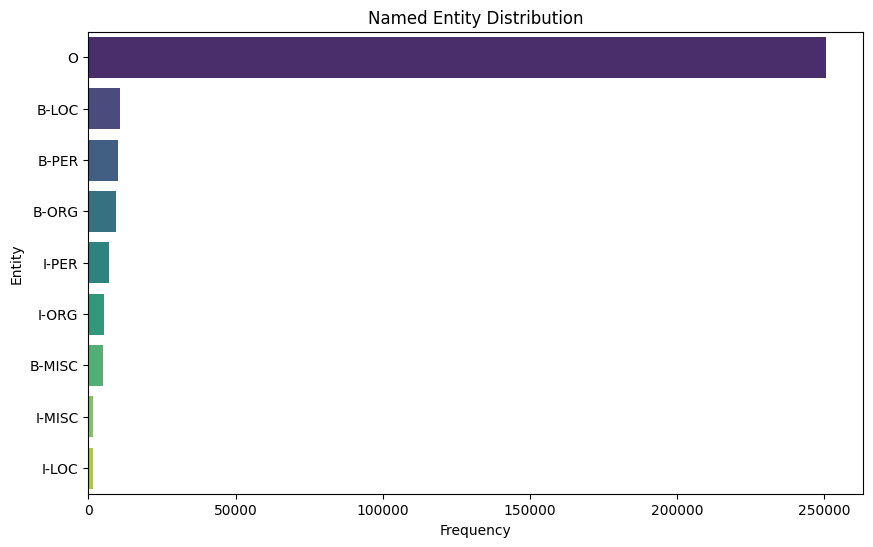

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


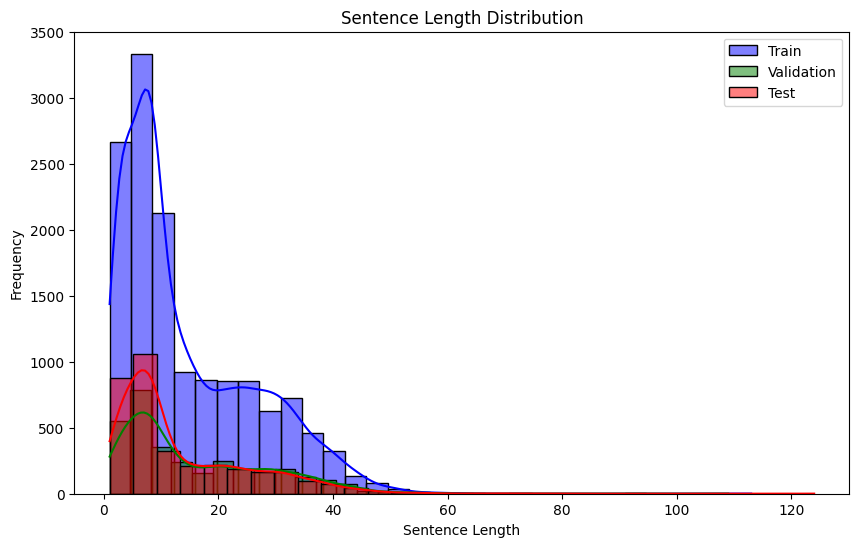

In [61]:
dataset = ner_dataset
def dataset_to_dataframe(dataset_split):
    tokens, ner_tags = [], []
    for example in dataset_split:
        tokens.extend(example['tokens'])
        ner_tags.extend(example['ner_tags'])
    return pd.DataFrame({'tokens': tokens, 'ner_tags': ner_tags})

df_train = dataset_to_dataframe(dataset['train'])
df_validation = dataset_to_dataframe(dataset['validation'])
df_test = dataset_to_dataframe(dataset['test'])

ner_tag_list = dataset['train'].features['ner_tags'].feature.names
df_train['ner_tags'] = df_train['ner_tags'].apply(lambda x: ner_tag_list[x])
df_validation['ner_tags'] = df_validation['ner_tags'].apply(lambda x: ner_tag_list[x])
df_test['ner_tags'] = df_test['ner_tags'].apply(lambda x: ner_tag_list[x])

df_all = pd.concat([df_train, df_validation, df_test], ignore_index=True)

def eda_conll2003(df):
    print("Basic Information:")
    print(df.info())
    print("\n")
    
    print("First few rows:")
    print(df.head())
    print("\n")
    
    print("Token and Entity Distribution:")
    token_counts = df['tokens'].value_counts().head(10)
    ner_tag_counts = df['ner_tags'].value_counts()
    print(token_counts)
    print("\n")
    print(ner_tag_counts)
    print("\n")
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=token_counts.values, y=token_counts.index, palette='viridis')
    plt.title('Most Frequent Tokens')
    plt.xlabel('Frequency')
    plt.ylabel('Token')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=ner_tag_counts.values, y=ner_tag_counts.index, palette='viridis')
    plt.title('Named Entity Distribution')
    plt.xlabel('Frequency')
    plt.ylabel('Entity')
    plt.show()
    
    def sentence_lengths(dataset_split):
        lengths = [len(example['tokens']) for example in dataset_split]
        return lengths

    train_lengths = sentence_lengths(dataset['train'])
    validation_lengths = sentence_lengths(dataset['validation'])
    test_lengths = sentence_lengths(dataset['test'])

    plt.figure(figsize=(10, 6))
    sns.histplot(train_lengths, bins=30, kde=True, color='blue', label='Train')
    sns.histplot(validation_lengths, bins=30, kde=True, color='green', label='Validation')
    sns.histplot(test_lengths, bins=30, kde=True, color='red', label='Test')
    plt.title('Sentence Length Distribution')
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

eda_conll2003(df_all)

# **Model**

## Named Entity Recognition

### Data split

In [62]:
train_tokens, train_labels = flatten_conll_dataset(ner_dataset['train'])
test_tokens, test_labels = flatten_conll_dataset(ner_dataset['test'])
val_tokens, val_labels = flatten_conll_dataset(ner_dataset['validation'])


vectorizer = TfidfVectorizer(max_features=10000)
X_ner_train = vectorizer.fit_transform(train_tokens)
X_ner_test = vectorizer.transform(test_tokens)
X_ner_val = vectorizer.transform(val_tokens)


label_encoder = LabelEncoder()
y_ner_train = label_encoder.fit_transform(train_labels)
y_ner_test = label_encoder.transform(test_labels)
y_ner_val = label_encoder.transform(val_labels)


label_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

In [63]:
print(X_ner_train.shape)
print(X_ner_val.shape)
print(X_ner_test.shape)

(203621, 10000)
(51362, 10000)
(46435, 10000)


In [64]:
# #print(classification_report(y_test, y_pred, target_names=label_names))
def convert():
  int_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Replace with your actual integer labels
  tag = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
  reverse_tag = {v: k for k, v in tag.items()}
  string_labels = [reverse_tag[label] for label in int_labels]
  return string_labels
# print(classification_report(y_test, y_pred, target_names=convert()))

### XGB Model

In [65]:
import xgboost as xgb
n_estimators = 100
ner_model = xgb.XGBClassifier(tree_method = 'hist', device="cuda", n_estimators = n_estimators)
ner_model.fit(X_ner_train, y_ner_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [66]:
y_ner_val_predict = ner_model.predict(X_ner_val)
print('precision: ',precision_score(y_ner_val, y_ner_val_predict, average = 'weighted'))
print(classification_report(y_ner_val, y_ner_val_predict, target_names=convert()))

precision:  0.8660579051622469
              precision    recall  f1-score   support

           O       0.87      1.00      0.93     42759
       B-PER       0.90      0.19      0.31      1842
       I-PER       0.79      0.05      0.09      1307
       B-ORG       0.73      0.15      0.24      1341
       I-ORG       0.78      0.11      0.19       751
       B-LOC       0.92      0.41      0.57      1837
       I-LOC       0.68      0.43      0.53       257
      B-MISC       0.93      0.41      0.57       922
      I-MISC       0.70      0.33      0.45       346

    accuracy                           0.87     51362
   macro avg       0.81      0.34      0.43     51362
weighted avg       0.87      0.87      0.83     51362



In [67]:
print(accuracy_score(y_ner_val, y_ner_val_predict))

0.8710135898134808


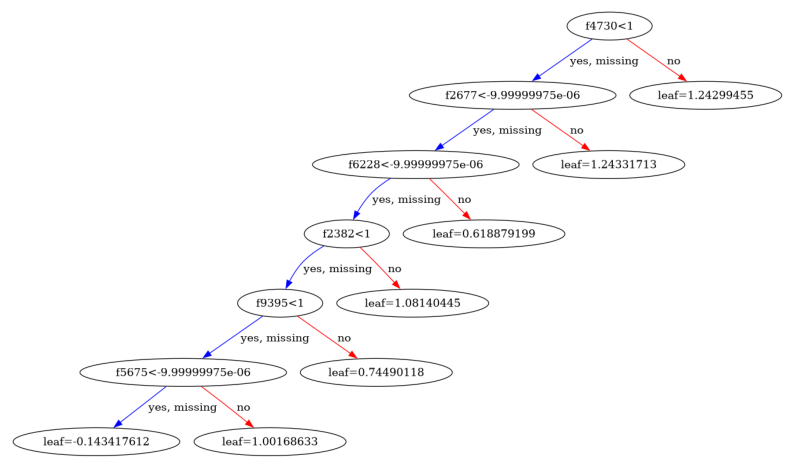

In [68]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_tree(ner_model, num_trees=4, ax=ax, rankdir = 'LB')
plt.show()

## Text some thing

In [69]:
def preprocess_text(text):
  tokens = re.findall(r'\b\w+\b', text)
  return tokens

def predict_ner(text):
  tokens = preprocess_text(text)
  X_input = vectorizer.transform(tokens)
  y_pred = ner_model.predict(X_input)

  tag = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
  reverse_tag = {v: k for k, v in tag.items()}
  predicted_labels = [reverse_tag[label] for label in y_pred]
  result = list(zip(tokens, predicted_labels))
  return result

In [70]:
# input_text = input("text here ")
input_text = 'George Washington was the first president of the United States'
predictions = predict_ner(input_text)
print(predictions)

[('George', 'O'), ('Washington', 'B-LOC'), ('was', 'O'), ('the', 'O'), ('first', 'O'), ('president', 'O'), ('of', 'O'), ('the', 'O'), ('United', 'O'), ('States', 'I-LOC')]


# Fine tuning parameter

## Hyperopt 

In [71]:
!pip install hyperopt

In [72]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials , space_eval
from sklearn.model_selection import cross_val_score

### NER

In [75]:
space = {
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 10),
    'gamma': hp.quniform('gamma', 0, 0.5, 0.01),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 1),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 1)
}

def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])

    model = xgb.XGBClassifier(
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        device='cuda',
        tree_method = 'approx'
    )

    model.fit(X_ner_train, y_ner_train)
    y_pred = model.predict(X_ner_test)
    accuracy = accuracy_score(y_ner_test, y_pred)

    return {'loss': -accuracy, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best hyperparameters:", best)

100%|██████████| 100/100 [1:27:20<00:00, 52.41s/trial, best loss: -0.8826316356196834]
Best hyperparameters: {'colsample_bytree': 0.8036618670709809, 'gamma': 0.16, 'learning_rate': 0.5325818109045147, 'max_depth': 13.0, 'min_child_weight': 1.0, 'n_estimators': 580.0, 'reg_alpha': 0.10715360359894781, 'reg_lambda': 0.1854558606786038, 'subsample': 0.999984226036394}


In [76]:
best['max_depth'] = int(best['max_depth'])
best['n_estimators'] = int(best['n_estimators'])
model = xgb.XGBClassifier(
    max_depth=best['max_depth'],
    learning_rate=best['learning_rate'],
    n_estimators=best['n_estimators'],
    gamma=best['gamma'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    device = 'cuda',
    tree_method = 'approx'
).fit(X_ner_train, y_ner_train)


In [77]:
y_val_predict = model.predict(X_ner_val)

In [78]:
print(classification_report(y_ner_val, y_val_predict, target_names=convert()))

              precision    recall  f1-score   support

           O       0.91      1.00      0.95     42759
       B-PER       0.85      0.36      0.51      1842
       I-PER       0.65      0.17      0.27      1307
       B-ORG       0.73      0.42      0.53      1341
       I-ORG       0.68      0.22      0.34       751
       B-LOC       0.87      0.65      0.74      1837
       I-LOC       0.67      0.51      0.58       257
      B-MISC       0.86      0.62      0.72       922
      I-MISC       0.70      0.34      0.46       346

    accuracy                           0.90     51362
   macro avg       0.77      0.48      0.57     51362
weighted avg       0.89      0.90      0.88     51362



In [79]:
print(accuracy_score(y_ner_val, y_val_predict))

0.9000233635761847


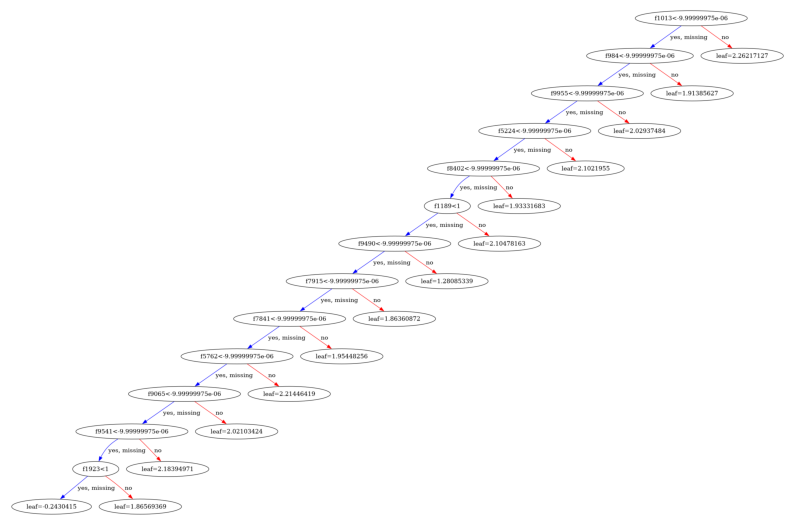

In [80]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_tree(model, num_trees=2, ax=ax, rankdir = 'LB')
plt.show()

In [81]:
#base model
y_test_predict = ner_model.predict(X_ner_test)

#fine tuning model
y_test_predict1 = model.predict(X_ner_test)

In [82]:
#base model
print(classification_report(y_ner_test, y_test_predict, target_names=convert()))

#fine tuning model
print(classification_report(y_ner_test, y_test_predict1, target_names=convert()))

              precision    recall  f1-score   support

           O       0.86      1.00      0.92     38323
       B-PER       0.94      0.13      0.22      1617
       I-PER       0.70      0.03      0.05      1156
       B-ORG       0.80      0.11      0.19      1661
       I-ORG       0.66      0.09      0.15       835
       B-LOC       0.90      0.37      0.53      1668
       I-LOC       0.70      0.34      0.46       257
      B-MISC       0.87      0.34      0.49       702
      I-MISC       0.56      0.46      0.51       216

    accuracy                           0.86     46435
   macro avg       0.78      0.32      0.39     46435
weighted avg       0.85      0.86      0.81     46435

              precision    recall  f1-score   support

           O       0.89      0.99      0.94     38323
       B-PER       0.85      0.25      0.38      1617
       I-PER       0.66      0.06      0.11      1156
       B-ORG       0.74      0.32      0.45      1661
       I-ORG       0.66 